<a href="https://colab.research.google.com/github/raheelam98/Agentic_Chatbots_with_langgraph/blob/main/Agentic_Chatbots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Agentic Chatbots
Autonomous systems that perform tasks, make decisions, and interact with users with minimal human intervention. Leveraging advanced AI, they understand context, learn from interactions, and provide personalized responses

Install the required packages:

In [6]:
# install the required packages

%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

API keys

In [8]:
# API Keys
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [9]:
# check graph is running
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("lang graph")

AIMessage(content='Please provide me with more information about what you\'d like to see in a "lang graph".  \n\nTo help me create the best possible graph for you, please tell me:\n\n* **What languages are you interested in?**  Do you want to see relationships between programming languages, natural languages, or something else?\n* **What kind of relationships are you interested in?**  For example, are you looking at:\n    * **Family trees:**  How languages are related to each other historically.\n    * **Popularity:**  How many people use different languages.\n    * **Compatibility:**  How well different languages can work together.\n    * **Features:**  Which languages have certain features in common.\n* **What format would you like the graph in?**  Would you prefer a:\n    * **Textual description:**  A list of languages and their relationships.\n    * **Diagram:**  A visual representation of the relationships between languages.\n    * **Interactive tool:**  A way to explore the relat

In [10]:
# check graph is running
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

response = llm.invoke([{"role": "user", "content": "greet me"}])

Chatbot with tools (part 2)

In [17]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [18]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

## Part 1: Build a Basic Chatbot

Create a chatbot that responds directly to user messages.

It is a large language model, trained by Google,

without access to real-time information (e.g., Karachi Weather) and

without retaining memory of previous interactions."

In [12]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Create a StateGraph instance with the State type
graph_builder = StateGraph(State)


# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# NOTE
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.

# Check if the node already exists before adding it
if "chatbot" not in graph_builder.nodes:
    graph_builder.add_node("chatbot", chatbot)
else:
    print("Node 'chatbot' already present.")

# # Adding nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()


**Visualize the graph**

Use get_graph to obtain the graph.

Choose a draw method (draw_ascii or draw_png).

Ensure you have the required dependencies installed for the chosen draw method.

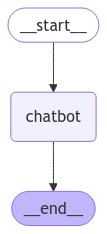

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Extracts the latest message from the use

In [14]:
# Loop through each event in the stream of events from the graph
for event in graph.stream({"messages": [("user", "I am Raheela")]}):
    # Print the latest message content from the user
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hello Raheela, it's nice to meet you! What can I do for you today? 



Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [25]:
def stream_graph_updates(user_input: str):
    # Loop through each event in the stream of events from the graph based on user input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Loop through each value in the event
        for value in event.values():
            # Print the latest message content from the Assistant
            print("Assistant:", value["messages"][-1].content)

# Continuously prompt the user for input
while True:
    try:
        # Get input from the user
        user_input = input("User: ")
        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            # Print a goodbye message and break the loop
            print("Goodbye!")
            break

        # Call the stream_graph_updates function with the user input
        stream_graph_updates(user_input)
    except:
        # Fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        # Print the fallback user input
        print("User: " + user_input)
        # Call the stream_graph_updates function with the fallback user input
        stream_graph_updates(user_input)
        break


User: q
Goodbye!


## Part 2: Enhancing the Chatbot with Tools

[Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

Added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.


#### Integrating tools for search results

Install the Required Packages to Add Tool (tavily-python and langchain_community) for Real-Time Search (e.g., Karachi Weather)

```bash
%%capture --no-stderr
%pip install -U tavily-python langchain_community
```

Setting the API key in the environment variable TAVILY_API_KEY

```bash
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
```

Next, define the tool

**`TavilySearchResults(max_results=2)`** initializes a search tool that retrieves and returns up to 2 search results.

Initializes a search tool that retrieves and returns up to 2 search results.
```bash
tool = TavilySearchResults(max_results=2)
tools = [tool]
```

**`bind_tools()`** Integrates the specified tools with the language model, enabling the model to invoke these tools during its execution

```bash
llm_with_tools = llm.bind_tools(tools)
```
This line integrates the tools list with the language model llm, resulting in a new instance (llm_with_tools) that can use these tools during its operations.

**`add_conditional_edges`** Define conditional edges for the chatbot node based on tool usage
```bash
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
```

**rm note**

**`ToolNode`** is a built-in function of LangGraph. We can create our own custom function that provides a list of tools such as a search engine, Excel file operations, weather search, or database search in SQL. To integrate these tools into LangGraph, pass them into a custom `ToolNode`. We’ll build our own `BasicToolNode` and replace LangGraph’s prebuilt `ToolNode` and `tools_condition` with it, using

ToolNode(tools=[your_tool]).


**ToolNode** is essentially a node within a workflow or graph that is designated to execute a specific tool or function when called.

**ToolNode** is a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls.

**ToolNode** is just a class that helps with this execution. You pass it your list of tools, and internally it stores them as name-function pairs.

**`add_conditional_edges()`** is a function used to add conditional connections between nodes in a graph, based on specific conditions. It helps create dynamic workflows where the next step depends on certain criteria being met.

**`graph_builder.add_conditional_edges("chatbot", tools_condition)`**

Purpose: Adds an edge from the `chatbot` node to another node, only if the `tools_condition` is satisfied.

In [22]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

#(part 1 : Basic Chatbot)
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

#(part 1 : Basic Chatbot)
# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)

# (Part 2: Enhancing the Chatbot with Tools)
# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

#(part 1 : Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#(part 1 : Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

#(part 1 : Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

#(part 1 : Basic Chatbot)
# Compile the graph
graph = graph_builder.compile()

 **Visualize the graph**

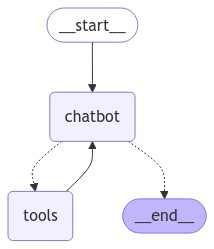

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

Chatbot Loop with Real-Time User Input Processing and No Memory Retention

In [26]:
# 1) Web search is available. 2) Does not maintain chat history (no memory).
while True:
    try:
        # Prompt the user for input
        user_input = input("User: ")
        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            # Print a goodbye message and break the loop
            print("Goodbye!")
            break

        # Call the stream_graph_updates function with the user input
        stream_graph_updates(user_input)
    except:
        # Fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        # Print the fallback user input
        print("User: " + user_input)
        # Call the stream_graph_updates function with the fallback user input
        stream_graph_updates(user_input)
        break


User: q
Goodbye!


## Part 3: Adding Memory to the Chatbot

**Memory checkpointing**

```bash
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
```
```bash
graph = graph_builder.compile(checkpointer=memory)
```
checkpointing the State as the graph works through each node.

**`graph = graph_builder.compile(checkpointer=MemorySaver())`**  compiles the graph with memory checkpointing, allowing it to save and restore the state of the graph's nodes during its execution.

To interact with the bot, first, pick a thread to use as the key for this conversation.
```bash
config = {"configurable": {"thread_id": "1"}}
```

The **chatbot can remember the state of the conversation within a given thread** but won't retain context if the thread ID is changed.

In [30]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# (Part 3: Adding Memory to the Chatbot)
memory = MemorySaver()

# (Part 1: Basic Chatbot)
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

# (Part 1: Basic Chatbot)
# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)

# (Part 2: Enhancing the Chatbot with Tools)
# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Integrate LLM with bind_tools for web search
llm_with_tools = llm.bind_tools(tools)

# (Part 1: Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# (Part 1: Basic Chatbot)
# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# (Part 1: Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# (Part 1: Basic Chatbot)
# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

# (Part 3: Adding Memory to the Chatbot)
# Compile the graph with memory checkpointing
graph = graph_builder.compile(checkpointer=MemorySaver())


 **Visualize the graph**

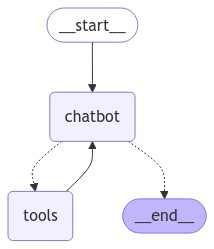

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [33]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [34]:
user_input = "Hi there! My name is Raheela."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Raheela.
================================== Ai Message ==================================

Hi Raheela, nice to meet you! 👋 What can I do for you today?


In [35]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


The **chatbot can remember the state of the conversation within a given thread** but won't retain context if the thread ID is changed.

In [36]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. I am a large language model, and I do not have the ability to store personal information like names. If you would like to tell me your name, I will be happy to remember it for this conversation.


goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

```bash
# Fetch the current state of the graph for the given configuration
snapshot = graph.get_state(config)

# Inspect the snapshot
snapshot

```

Retrieve the next node to execute (empty if the graph ended this turn)

```bash
snapshot.next
```
(since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

## Part 4: Human-in-the-loop

**Freezer and un unfreez node**

LangGraph's interrupt_before functionality to always break the tool node.

```bash
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["tools"])
```
**`interrupt_before=["tools"]`**   This is new!

Note: can also interrupt __after__ tools, if desired.
**`interrupt_after=["tools"]`**

**`get_state()`**  Retrieve the current state or status of a particular object

**`.next`** Find out what the next node to execute

**`.config`** Show the current configuration of the state

**`.value`**  Show all values

* `snapshot = graph.get_state(config)`  # Retrieve the current state or status of the graph
* `snapshot.config`  # Show the current configuration of the state
* `snapshot.next`  # Retrieve the next node that will execute in the graph. If the graph ended this turn, next will be empty

```bash
snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
snapshot.next  # Find out what the next node to execute is
snapshot.config  # Show the current configuration of the state
snapshot.values  # Show values
snapshot.values['messages']  # Show messages

existing_message = snapshot.values["messages"][-1]  # Find out the last message
existing_message.pretty_print()  # Print message

existing_message.tool_calls  # Get tool data
```

In [38]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# (Part 1: Basic Chatbot)
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

# (Part 1: Basic Chatbot)
# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)


# (Part 2: Enhancing the Chatbot with Tools)
# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Integrate LLM with bind_tools for web search
llm_with_tools = llm.bind_tools(tools)

# (Part 1: Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# (Part 1: Basic Chatbot)
# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# (Part 1: Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# (Part 1: Basic Chatbot)
# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

# (Part 3: Adding Memory to the Chatbot)
memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,
    # This is new! (Part 4: Human-in-the-loop)
    interrupt_before=["tools"],  #interrupt_before the tools node
)

In [39]:
print(graph)

In [40]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [41]:
#inspect the graph state to confirm it worked.
snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
snapshot.next   # Retrieve the next node that will execute in the graph

('tools',)

Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here! Let's check the tool invocation.

In [42]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': '8da7f130-7ebe-43c7-b32c-480e18ed9dbc',
  'type': 'tool_call'}]

`None` will append nothing new to the current state, letting it resume as if it had never been interrupted

```bash
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
```        

## Part 5: Manually Updating the State